# Credit Card Fraud Detection

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report, f1_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
import itertools
import pickle
import warnings
warnings.filterwarnings("ignore")

Dataset Link: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [16]:
df_original = pd.read_csv('creditcard.csv')
df_original.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [17]:
# Creating a copy of original dataframe to later apply different transformations
df = df_original.copy()

In [18]:
# Checking the shape of data
df.shape

(284807, 31)

In [19]:
# Checking data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [20]:
# Checking for null values
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [21]:
# Statistical Summary of data
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


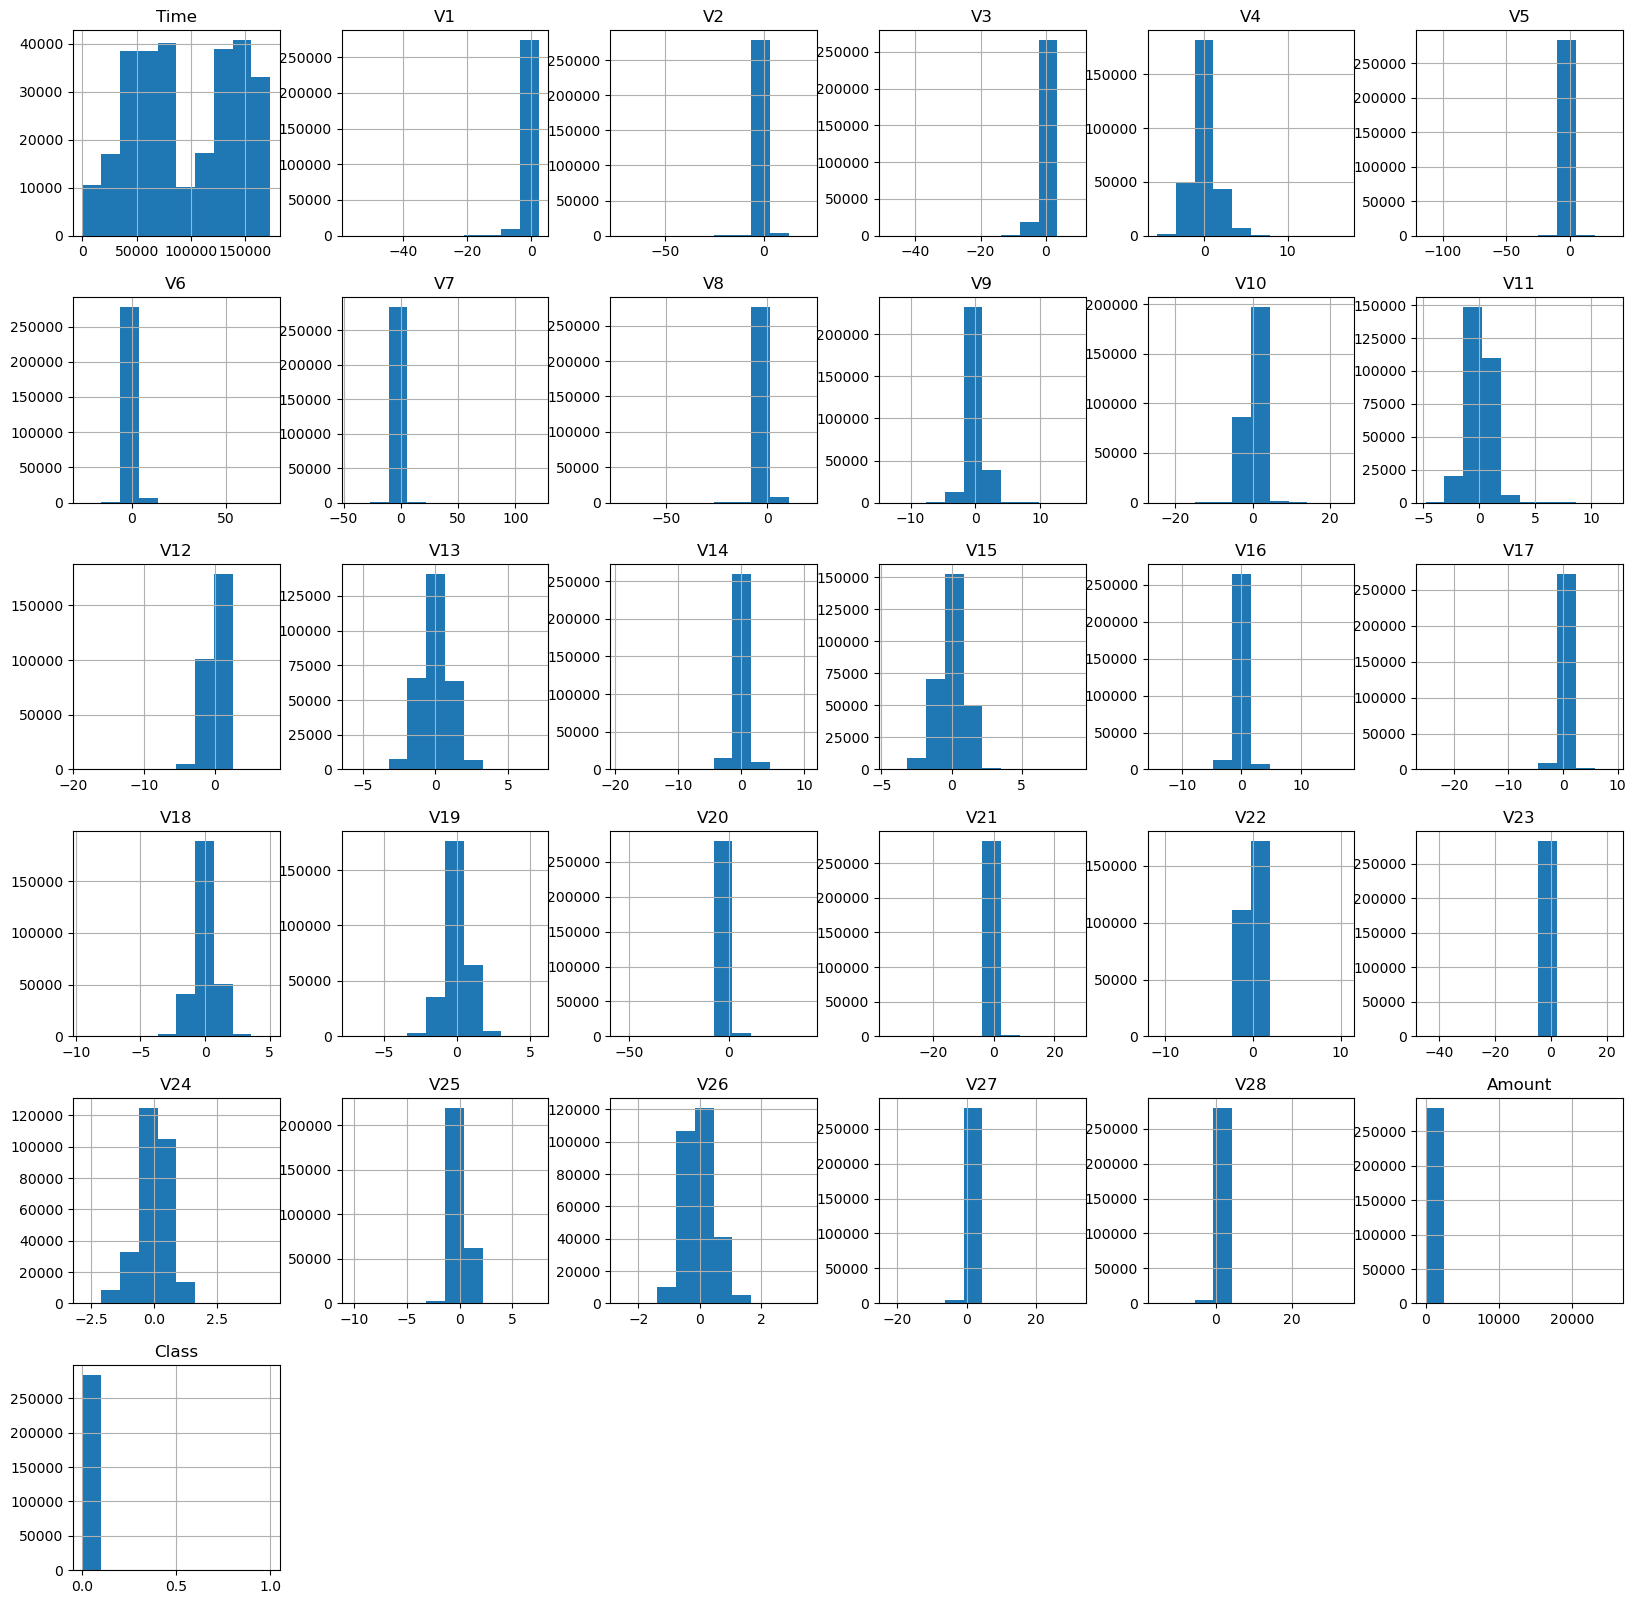

In [75]:
# Checking distribution of all features
df.hist(figsize=(20,20));

Text(0.5, 1.0, 'Time Vs Class')

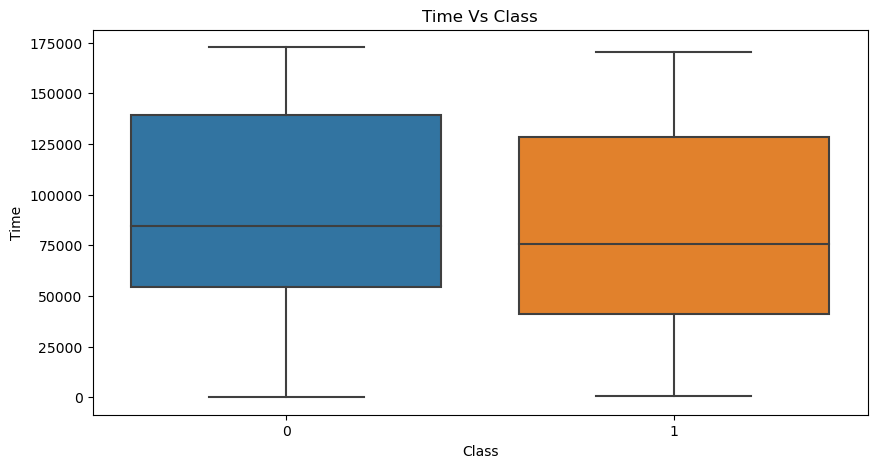

In [76]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Class', y ='Time', data=df)
plt.title("Time Vs Class")

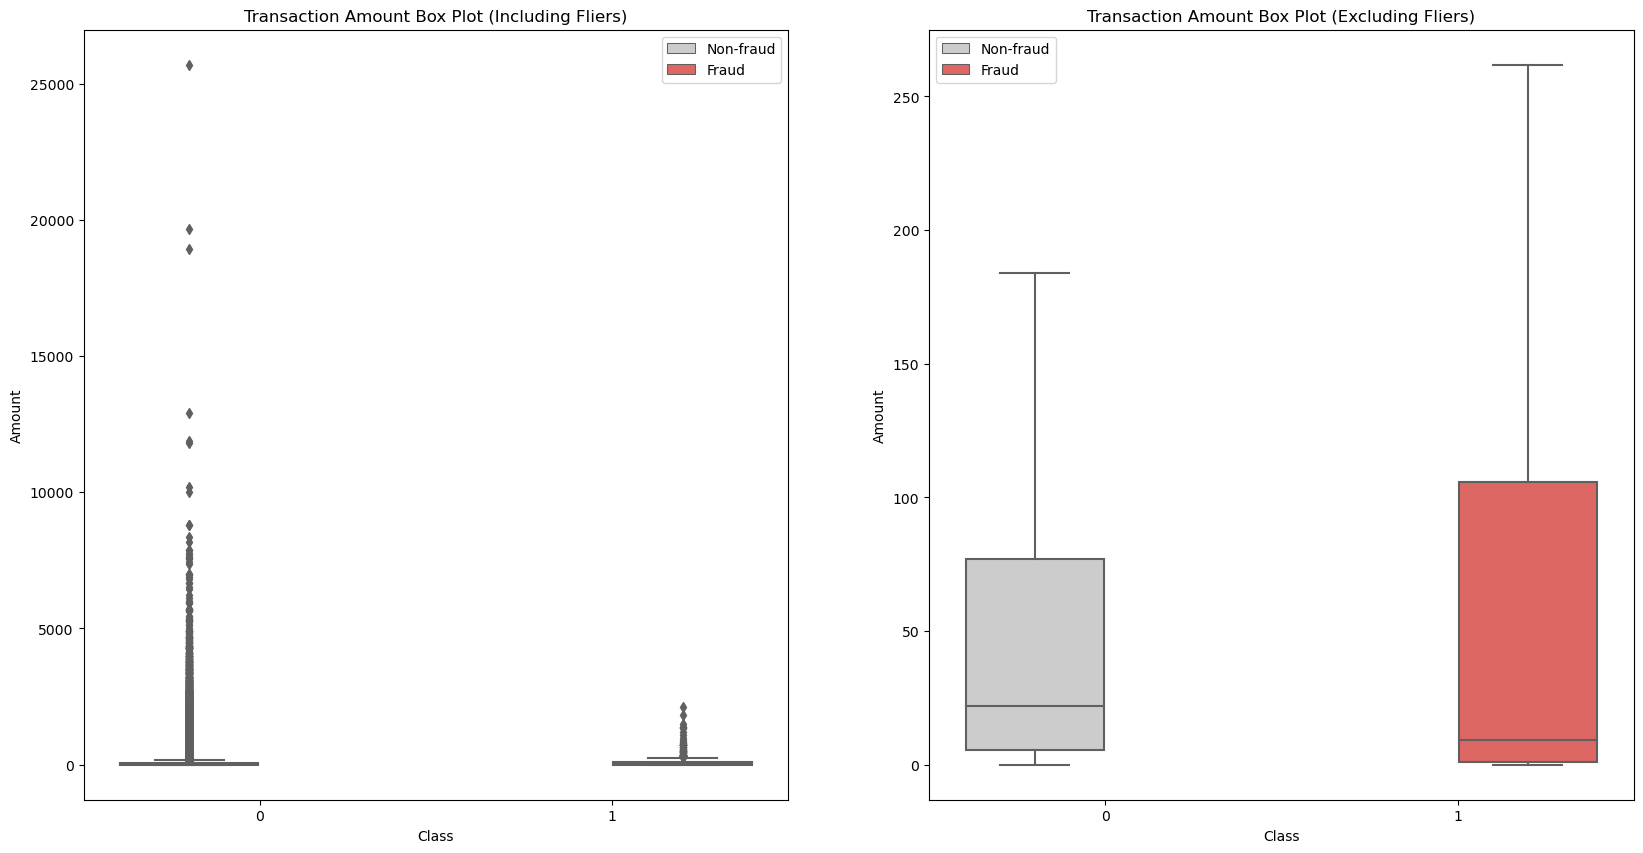

In [77]:
# Custom colors for our data

gray_color = "#CCCCCC" # Grey for regular txs
red_color = "#F0544F" # Red for fraudulent txs
blue_color = "#8CA6F2" # Blue for heatmap
gold_color = '#F2D98C' # Gold for heatmap
green_color = '#A4F28C'# Green for confusion matrix
white_color = '#FFFFFF' # White for confusion matrix

color_pal = [gray_color, red_color]

fig, ax = plt.subplots(ncols=2, figsize=(20,10))

sns.boxplot(data=df, 
            x="Class", 
            y="Amount", 
            hue="Class",
            palette=color_pal,
            showfliers=True,
            ax=ax[0])

sns.boxplot(data=df, 
            x="Class", 
            y="Amount", 
            hue="Class",
            palette=color_pal,
            showfliers=False,
            ax=ax[1])

# Add titles to the plots
ax[0].set_title("Transaction Amount Box Plot (Including Fliers)")
ax[1].set_title("Transaction Amount Box Plot (Excluding Fliers)")

# Update legend labels
legend_labels = ['Non-fraud', 'Fraud']
for i in range(2):
    handles, _ = ax[i].get_legend_handles_labels()
    ax[i].legend(handles, legend_labels)


plt.show()

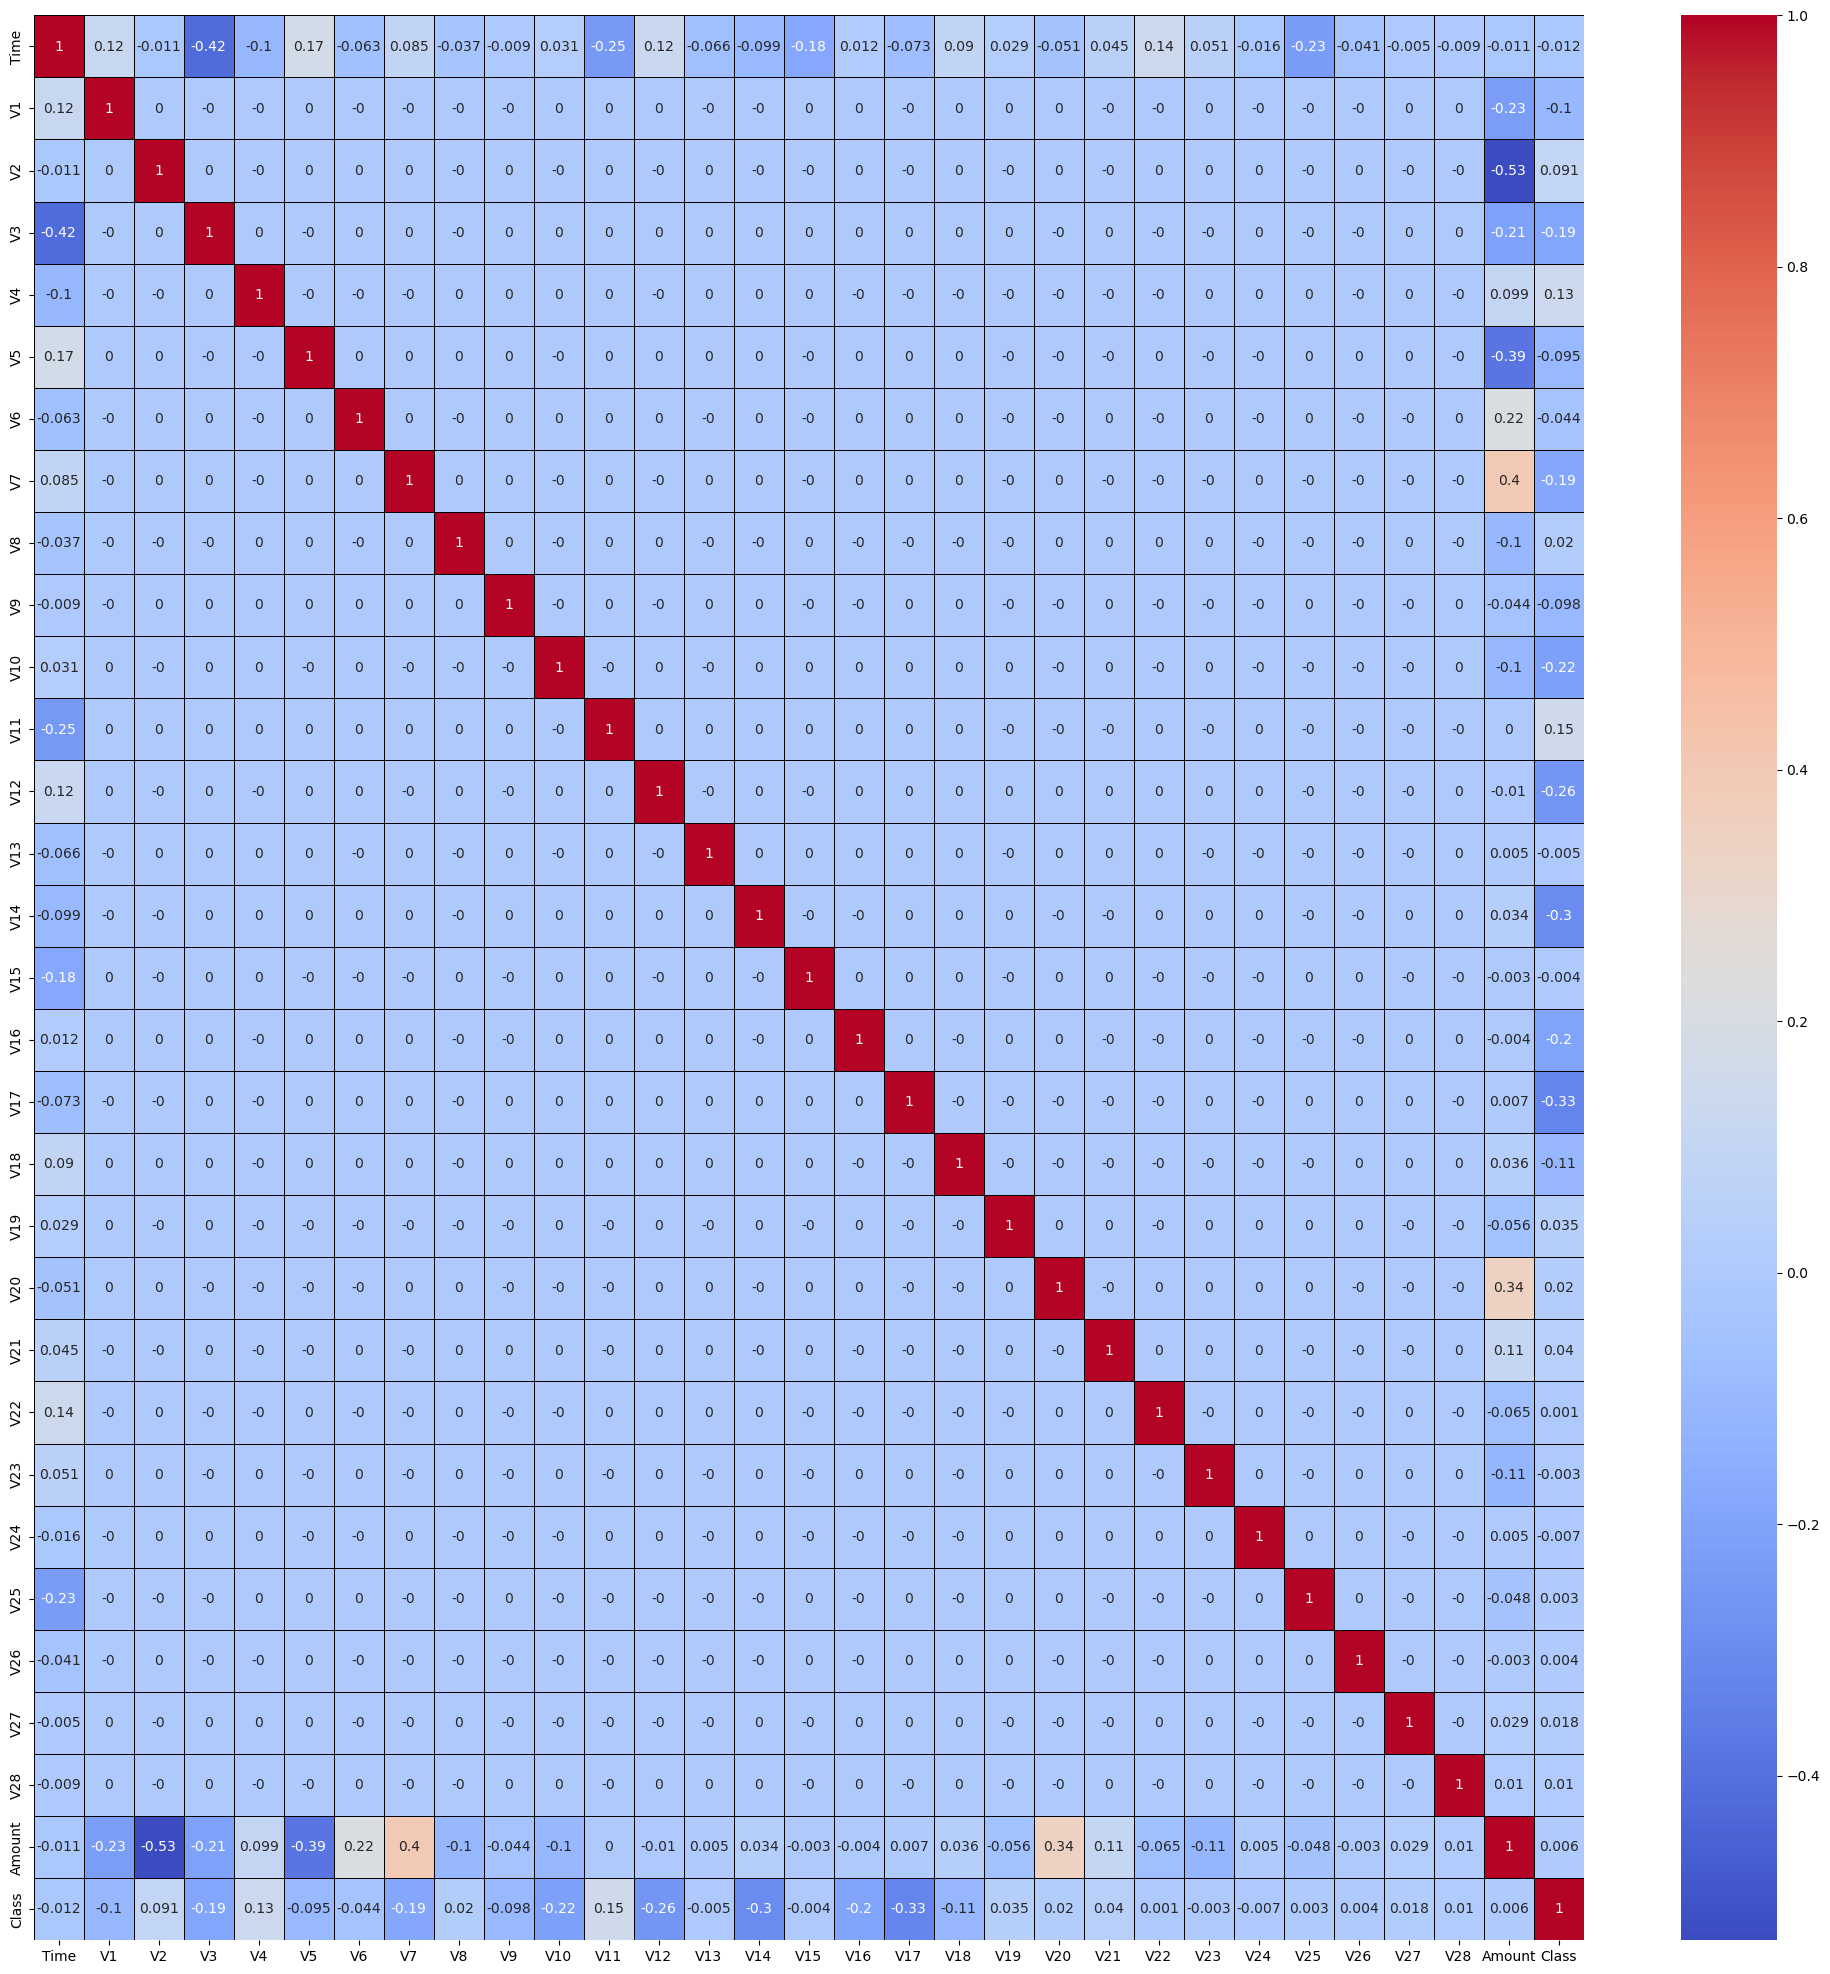

In [78]:
# correlation between all numerical features 
plt.figure(figsize=(25,25))
sns.heatmap(round(df.corr(),3),annot = True,cmap = 'coolwarm',
            linewidths = 0.5 ,linecolor='black')# plotting correlation heatmap
plt.show()

<AxesSubplot:xlabel='Class', ylabel='count'>

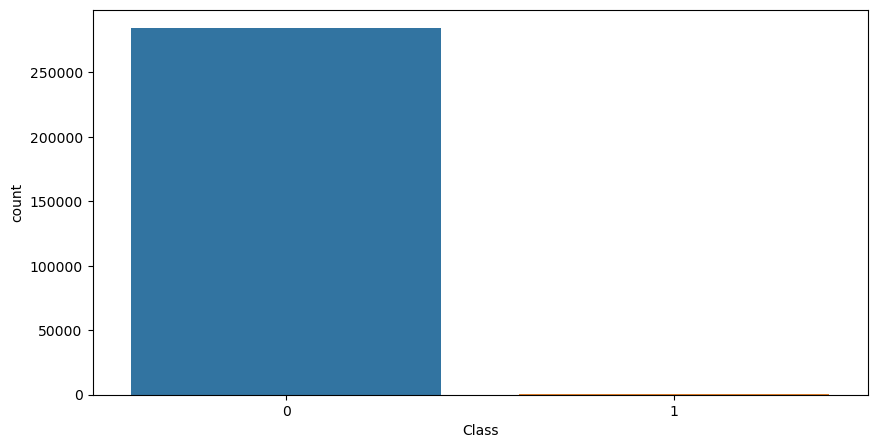

In [79]:
# Checking class distribution
plt.figure(figsize=(10,5))
sns.countplot(x='Class', data=df)

In [80]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [22]:
X = df.drop('Class', axis=1)
y = df['Class']

## Creating Models on Imbalanced Data

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.30, random_state=42)

In [24]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (199364, 30)
y_train shape: (199364,)
X_test shape: (85443, 30)
y_test shape: (85443,)


In [25]:
# Data Scaling
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Logistic Regression

In [67]:
# Baseline model

lr = LogisticRegression()

lr.fit(X_train_scaled, y_train)

LogisticRegression()

In [68]:
lr_pred = lr.predict(X_test_scaled)

print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.86      0.63      0.73       148

    accuracy                           1.00     85443
   macro avg       0.93      0.81      0.86     85443
weighted avg       1.00      1.00      1.00     85443



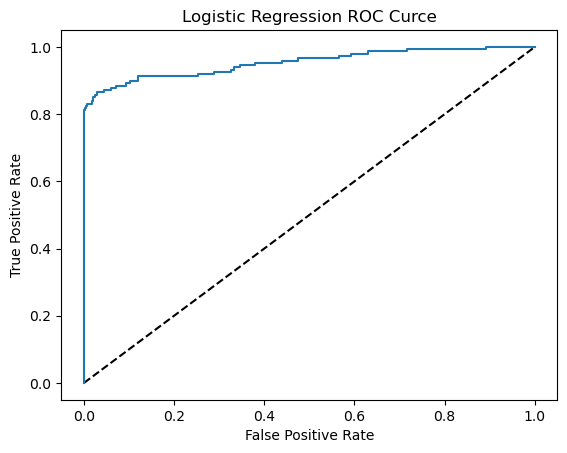

In [87]:
lr_pred_prob = lr.predict_proba(X_test_scaled)[:,1]
roc_auc_score(y_test, lr_pred_prob)

fpr, tpr, thresholds = roc_curve(y_test, lr_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curce')
plt.show();

#### XGBoost

In [26]:
xgb = XGBClassifier()

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [27]:
xgb_pred = xgb.predict(X_test)

print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.94      0.78      0.85       148

    accuracy                           1.00     85443
   macro avg       0.97      0.89      0.93     85443
weighted avg       1.00      1.00      1.00     85443



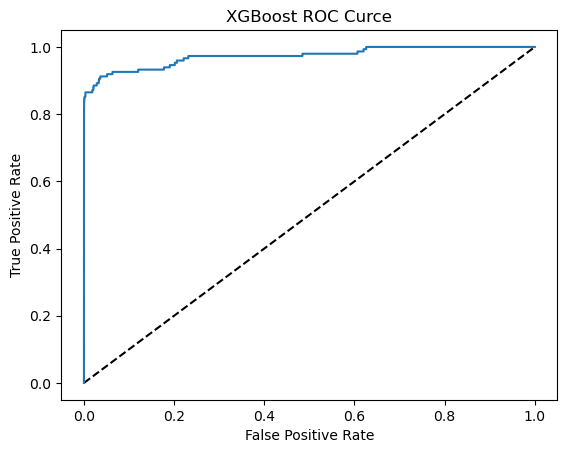

In [28]:
xgb_pred_prob = xgb.predict_proba(X_test)[:,1]
roc_auc_score(y_test, xgb_pred_prob)

fpr, tpr, thresholds = roc_curve(y_test, xgb_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curce')
plt.show();

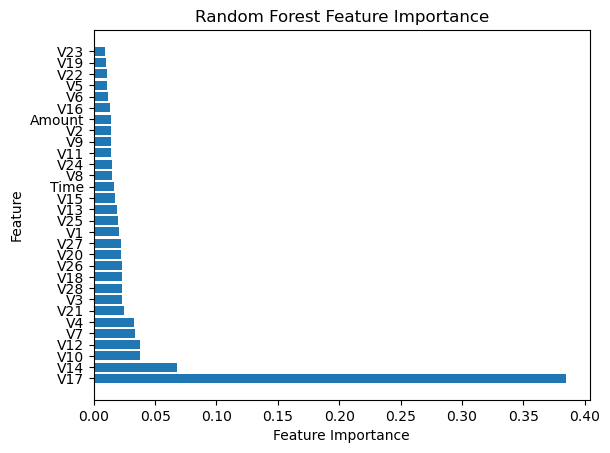

In [29]:
feature_importance = xgb.feature_importances_
feature_names = X_train.columns

feature_importance_dict = dict(zip(feature_names, feature_importance))

sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# for feature, importance in sorted_feature_importance:
#     print(f"{feature}: {importance}")

plt.barh(*zip(*sorted_feature_importance))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.show()

In [30]:
sorted_feature_importance

[('V17', 0.3849452),
 ('V14', 0.06790204),
 ('V10', 0.03749719),
 ('V12', 0.037461657),
 ('V7', 0.033717617),
 ('V4', 0.032852907),
 ('V21', 0.024369359),
 ('V3', 0.023385959),
 ('V28', 0.023131244),
 ('V18', 0.02298484),
 ('V26', 0.022748005),
 ('V20', 0.022575632),
 ('V27', 0.02243493),
 ('V1', 0.02073343),
 ('V25', 0.01944202),
 ('V13', 0.018767748),
 ('V15', 0.017668419),
 ('Time', 0.016108518),
 ('V8', 0.015149863),
 ('V24', 0.014639133),
 ('V11', 0.014288657),
 ('V9', 0.014225921),
 ('V2', 0.014023873),
 ('Amount', 0.013849994),
 ('V16', 0.013563101),
 ('V6', 0.011269145),
 ('V5', 0.011079141),
 ('V22', 0.0104455585),
 ('V19', 0.009778191),
 ('V23', 0.0089607285)]

In [31]:
selected_features = []

# Loop through the sorted feature importance and store names with importance > 0.30
for feature, importance in sorted_feature_importance:
    if importance < 0.013563101:
        continue
    selected_features.append(feature)

# Now, selected_features contains the names of features with importance > 0.30
print("Selected Features:", selected_features)

Selected Features: ['V17', 'V14', 'V10', 'V12', 'V7', 'V4', 'V21', 'V3', 'V28', 'V18', 'V26', 'V20', 'V27', 'V1', 'V25', 'V13', 'V15', 'Time', 'V8', 'V24', 'V11', 'V9', 'V2', 'Amount', 'V16']


#### Random Forest Classifier

In [69]:
rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)

RandomForestClassifier()

In [70]:
rfc_pred = rfc.predict(X_test)

print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.96      0.75      0.84       148

    accuracy                           1.00     85443
   macro avg       0.98      0.87      0.92     85443
weighted avg       1.00      1.00      1.00     85443



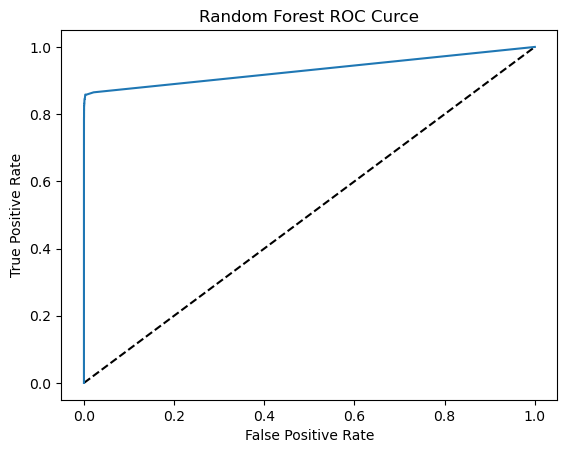

In [99]:
rfc_pred_prob = rfc.predict_proba(X_test)[:,1]
roc_auc_score(y_test, rfc_pred_prob)

fpr, tpr, thresholds = roc_curve(y_test, rfc_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='RFC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curce')
plt.show();

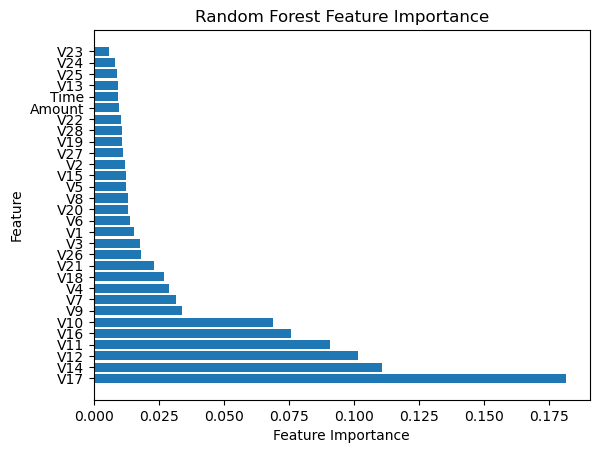

In [101]:
# Get feature importance
feature_importance_rfc = rfc.feature_importances_
feature_names = X_train.columns 

feature_importance_dict = dict(zip(feature_names, feature_importance_rfc))
sorted_feature_importance_rfc = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# for feature, importance in sorted_feature_importance_rfc:
#     print(f"{feature}: {importance}")

# Plot feature importance
plt.barh(*zip(*sorted_feature_importance_rfc))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.show()

## Balancing the data by doing Undersampling

In [117]:
# !pip install -U threadpoolctl

In [50]:
class_0_samples = df[df['Class'] == 0].sample(n=1500, random_state=42)
class_1_samples = df[df['Class'] == 1]

df_us = pd.concat([class_0_samples, class_1_samples])
df_us = df_sm.sample(frac=1, random_state=42).reset_index(drop=True)

In [51]:
df_us.shape

(1992, 31)

In [53]:
selected_features.append('Class')

In [54]:
df_us = df_us[selected_features]

In [55]:
X_us= df_us.drop(columns=['Class'])
y_us = df_us['Class']

In [56]:
X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(X_us, y_us, stratify = y_us, test_size=0.25, random_state=42)

In [57]:
df_us['Class'].value_counts()

0    1500
1     492
Name: Class, dtype: int64

In [58]:
scaler_us = StandardScaler()

scaler_us.fit(X_train_us)

X_train_us_sc = scaler_us.transform(X_train_us)
X_test_us_sc = scaler_us.transform(X_test_us)

## Creating Models with Balanced data

#### Logistic Regression

In [59]:
lr2 = LogisticRegression()

lr2.fit(X_train_us_sc, y_train_us)

LogisticRegression()

In [60]:
lr2_pred = lr2.predict(X_test_us_sc)

print(classification_report(y_test_us, lr2_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       375
           1       0.96      0.88      0.92       123

    accuracy                           0.96       498
   macro avg       0.96      0.93      0.94       498
weighted avg       0.96      0.96      0.96       498



#### XGBoost

In [61]:
xgb2 = XGBClassifier()

xgb2.fit(X_train_us, y_train_us)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [62]:
xgb2_pred = xgb2.predict(X_test_us)

print(classification_report(y_test_us, xgb2_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       375
           1       0.98      0.87      0.92       123

    accuracy                           0.96       498
   macro avg       0.97      0.93      0.95       498
weighted avg       0.96      0.96      0.96       498



#### Random Forest Classifier

In [63]:
rfc2 = RandomForestClassifier()

rfc2.fit(X_train_us, y_train_us)

RandomForestClassifier()

In [64]:
rfc2_pred = rfc2.predict(X_test_us)

print(classification_report(y_test_us, rfc2_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       375
           1       0.98      0.86      0.92       123

    accuracy                           0.96       498
   macro avg       0.97      0.93      0.95       498
weighted avg       0.96      0.96      0.96       498



In [76]:
lr_re = recall_score(y_test, lr_pred)
lr2_re1 = recall_score(y_test_us, lr2_pred)

xgb_re = recall_score(y_test, xgb_pred)
xgb2_re1 = recall_score(y_test_us, xgb2_pred)

rfc_re = recall_score(y_test, rfc_pred)
rfc2_re1 = recall_score(y_test_us, rfc2_pred)

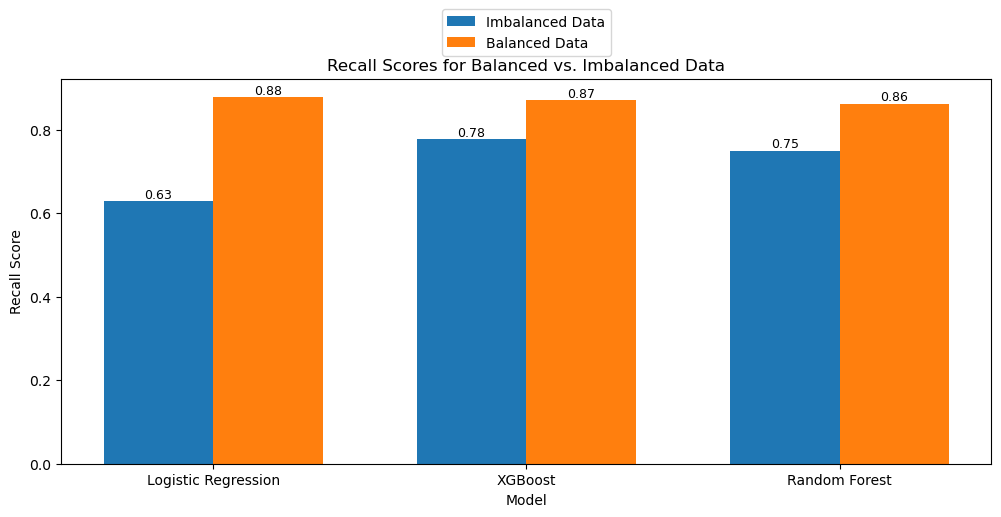

In [96]:
models = ['Logistic Regression', 'XGBoost', 'Random Forest']
recall_scores_imb = [lr_re, xgb_re, rfc_re]  # F1 scores for imbalanced data
recall_scores_bal = [lr2_re1, xgb2_re1, rfc2_re1]  # F1 scores for balanced data

bar_width = 0.35
imb_pos = np.arange(len(models))
bal_pos = imb_pos + bar_width

fig, ax = plt.subplots(figsize=(12,5))
plt.title('Recall Scores for Balanced vs. Imbalanced Data')
plt.xlabel('Model')
plt.ylabel('Recall Score')

imb_bars = ax.bar(imb_pos, recall_scores_imb, width=bar_width, label='Imbalanced Data')
bal_bars = ax.bar(bal_pos, recall_scores_bal, width=bar_width, label='Balanced Data')

# Add annotations on top of each bar
for imb_bar, bal_bar, imb_score, bal_score in zip(imb_bars, bal_bars, recall_scores_imb, recall_scores_bal):
    ax.text(imb_bar.get_x() + imb_bar.get_width() / 2, imb_bar.get_height(),
            f'{imb_score:.2f}', ha='center', va='bottom', fontsize=9, color='black')
    ax.text(bal_bar.get_x() + bal_bar.get_width() / 2, bal_bar.get_height(),
            f'{bal_score:.2f}', ha='center', va='bottom', fontsize=9, color='black')

tick_pos = np.arange(len(models))
ax.set_xticks(tick_pos + bar_width / 2)
ax.set_xticklabels(models)

plt.legend(loc='center', bbox_to_anchor=(0.5, 1.12))

plt.show()


#### Cross validating XGBoost using balanced data

In [ ]:
def cross_validation(model, X, y, cv=3, scoring='f1'):
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    return cv_scores

In [100]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
xgb_recalls = cross_val_score(xgb2, X_us, y_us, cv=kfold, scoring='recall')

In [101]:
recall_mean = xgb_recalls.mean()

In [108]:
# Mean F1-Score from cross validation
print("Cross validation results across 5-Folds:", xgb_recalls)
print("Mean Recall score from cross validation:", recall_mean)

Cross validation results across 5-Folds: [0.82407407 0.90277778 0.88461538 0.90196078 0.89622642]
Mean Recall score from cross validation: 0.8819308871750602


### Hyper Parameter tuning

In [105]:
# Define the hyperparameter grid to search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'n_estimators': [100, 200, 300, 400, 500],
}

random_search = RandomizedSearchCV(
    xgb2,
    param_distributions=param_grid,
    scoring='recall',
    cv=5, 
    verbose=1,
    n_jobs=-1,  # Use all available CPUs
    random_state=42,
)

random_search.fit(X_train_us, y_train_us)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                                        'min_child_weight': [1, 2, 3, 4, 5],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'subsample': [0.8, 0.9, 1.0]},
                   random_state=42, scoring='recall', verbose=1)

In [106]:
# best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 4, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.9}


In [111]:
# Evaluate the model on the test set using the best hyperparameters
xgb_tuned = random_search.best_estimator_
tuned_recall = xgb_tuned.score(X_test_us, y_test_us)
print(f"Recall on Test Set: {tuned_recall:.4f}")

Recall on Test Set: 0.9659


# <center>--- THE END ---

In [116]:
# pickle.dump(xgb2, open('xgb_untuned.pkl','wb'))
# pickle.dump(xgb_tuned, open('xgb_tuned.pkl','wb'))